#  Download Hansen Forest Change

In this notebook, we download layers from the [Hansen Dataset](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html) using FarmVibes.AI and visualize it. The data, distributed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/), illustrates how forests changed from 2000 to 2022 with 30 meter resolution and covers the whole planet. Users can use this dataset to observe how the forest changed over time in a region of interest.

This global dataset, split into 10x10 degree tiles, contains seven files per tile. Each file has unsigned 8-bit values and a resolution of around 30 meters per pixel at the equator. The dataset includes the following layers:

 - `treecover2000`: Tree cover in the year 2000, defined as canopy closure for all vegetation taller than 5m in height. Encoded as a percentage per output grid cell, in the range 0–100.
 - `gain`: Forest gain during the period 2000-2012, defined as the inverse of loss, or a non-forest to forest change entirely within the study period. Encoded as either 1 (gain) or 0 (no gain).
 - `lossyear`: Forest loss during the period 2000-2022, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1-22, representing loss detected primarily in the year 2001-2022, respectively.
 - `datamask`: Three values representing areas of no data (0), mapped land surface (1), and persistent water bodies (2) based on 2000-2012.
 - `first`: Circa year 2000 Landsat 7 cloud-free image composite (first).
Reference multispectral imagery from the first available year, typically 2000. 
 - `last`: cloud-free image composites for the last year in the series (e.g., 2022). 
 
 Only the 'lossyear' and 'last' categories are updated annually. The reflectance values in the imagery are scaled to an 8-bit data range.

Dataset Reference:

Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. High-Resolution Global Maps of 21st-Century Forest Cover Change. Science 342 (15 November): 850-53. Data available on-line from: https://glad.earthengine.app/view/global-forest-change.

### Micromamba environment setup
To install the required packages, see [this README file](../README.md). You can activate the environment with the following command:


```bash
$ micromamba activate farmvibes-ai
```

In [1]:
from datetime import datetime
from typing import cast

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
from shapely import geometry as shpg
from shapely.geometry import box

from vibe_core.client import get_default_vibe_client
from vibe_core.data import Raster
from vibe_notebook.raster import read_raster

### Create Vibe client and document the hansen download workflow

Before executing the [workflow](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/WORKFLOWS.html), let's observe its documentation using a FarmVibes.AI python client.

In [2]:
client = get_default_vibe_client()

WORKFLOW_NAME = "data_ingestion/hansen/hansen_forest_change_download"
client.document_workflow(WORKFLOW_NAME)

Workflow: data_ingestion/hansen/hansen_forest_change_download

Description:

Downloads and merges Global Forest Change (Hansen) rasters that intersect the user-provided     
    geometry/time range. The workflow lists Global Forest Change (Hansen) products that intersect   
    the user-provided geometry/time range, downloads the data for each of them, and merges the      
    rasters. The dataset is available at 30m resolution and is updated annually. The data contains  
    information on forest cover, loss, and gain. The default dataset version is GFC-2022-v1.10 and  
    is passed to the workflow as the parameter tiles_folder_url. For the default version, the       
    dataset is available from 2000 to 2022.  Dataset details can be found at                        
    https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html.

Sources:

- input_item (vibe_core.data.core_types.DataVibe): User-provided geometry and time range.

Sinks:

- merged_raster (vibe_core.data.rasters.Raster): Merged Global Forest Change (Hansen) data as a 
    raster.

- downloaded_raster (vibe_core.data.rasters.Raster): Individual Global Forest Change (Hansen)   
    rasters prior to the merge operation.

Parameters:

- layer_name (default: None): Name of the Global Forest Change (Hansen) layer. Can be any of the
    following names 'treecover2000', 'loss', 'gain', 'lossyear', 'datamask', 'first', 'last'.

- tiles_folder_url (default:                                                                    
    https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/): URL to the Global   
    Forest Change (Hansen) dataset. It specifies the dataset version and is used to download the    
    data.

Tasks:

- list: Lists Global Forest Change (Hansen) products that intersect the user-provided           
    geometry/time range.

- download: Downloads Global Forest Change (Hansen) data.

- group: This op groups rasters in time according to 'criterion'.

- merge: Merges rasters in a sequence to a single raster.

### Setting up Input Geometry and Time Frame
 
Now, we will establish the desired geometry and time frame for downloading the Hansen products. The workflow will fetch and merge all the tiles that intersect with the given input.

In [3]:
# GeoJSON definition of a polygon over the potential forest area
geo_json = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-86.773827, 14.575496],
                [-86.770459, 14.579302],
                [-86.764283, 14.575102],
                [-86.769591, 14.567595],
                [-86.773827, 14.575496],
            ]
        ],
    },
    "properties": {},
}

geom = shpg.shape(geo_json["geometry"])
time_range = datetime(2000, 1, 1), datetime(2022, 1, 2)

### Run FarmVibes.AI Workflow

To execute the workflow users need to provide the geometry of interest (`geom`), time range (`time_range`), and the name of the layer to be downloaded as a workflow parameter (`layer_name`). The layer can be any value from the set (`treecover2000`, `gain`, `lossyear`, `datamask`, `first`, `last`).

In the next cell, we initiate two `runs` for the `treecover2000` and `lossyear` layers, and then wait for both workflows to complete (`client.monitor(runs)`).

In [4]:
runs = []

for layer_name in ["treecover2000", "lossyear"]:
    run = client.run(
        WORKFLOW_NAME,
        "Hansen dataset download",
        geometry=geom,
        time_range=time_range,
        parameters={"layer_name": layer_name},
    )
    runs.append(run)

client.monitor(runs)

Output()

### Visualizing Dataset Details
 
In the upcoming cells, we will depict the changes in the forest over the years within the user's region of interest. Following that, we will examine the division of the area in terms of forest and non-forest proportions. Finally, we will assess how the percentage of forest pixels has evolved over time.

#### Plot forest loss over time

In the following cell, we create a plot function that reads the `treecover2000` layer and the `lossyear`. The `treecover2000` layer has pixel values ranging from 0 to 100 that represents the percentage of tree cover in the area. Here, we use a black to green colormap. Then, we plot the `lossyear` with pixel values enconded as 0 (no loss) or else a value in the range 1-20, representing loss detected primarily in the year 2001-2022, respectively. The second layer is depicted using a yellow to red colormap. 

In [5]:
def plot_hansen_map(treecover2000: Raster, lossyear: Raster, geom: shpg.Polygon, first_year: int):
    colors = ["black", "green"]
    cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)

    # Define your geometry
    bounding_box = box(*geom.buffer(0.01).bounds)

    # Get the bounds of the geometry
    minx, miny, maxx, maxy = bounding_box.bounds

    merged_raster = cast(Raster, treecover2000)
    out_image = read_raster(merged_raster, bounding_box)[0]

    loss_image = read_raster(cast(Raster, lossyear), bounding_box)[0][0]

    # Create a masked array where the mask is True for zero values
    masked_loss = np.ma.masked_where(loss_image == 0, loss_image)

    # Set data type to float
    masked_loss = masked_loss.astype(float)
    masked_loss += first_year

    # Plot the cropped image with latitude and longitude in the axes
    plt.imshow(out_image[0], cmap=cmap, extent=[minx, maxx, miny, maxy])

    loss_cmap = plt.cm.get_cmap("YlOrRd").copy()
    loss_cmap.set_bad(color="none")

    # Plot the loss image on top of the cropped image
    plt.imshow(masked_loss, cmap=loss_cmap, alpha=0.8, extent=[minx, maxx, miny, maxy])

    # Plot geom on top of the cropped image
    plt.plot(*geom.exterior.xy, color="blue")

    # Add a legend for the loss_image
    cbar = plt.colorbar()
    tick_locator = ticker.MaxNLocator(nbins=max(loss_image.flatten()))
    cbar.locator = tick_locator
    cbar.update_ticks()

    cbar.set_label("Year for the forest to non-forest transition")

    plt.title("Forest Extent")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.text(
        0.11,
        -0.005,
        "Source: Hansen/UMD/Google/USGS/NASA",
        fontsize=7,
        transform=plt.gcf().transFigure,
    )

    plt.show()

### Plot the `treecover2000` and `lossyear` rasters

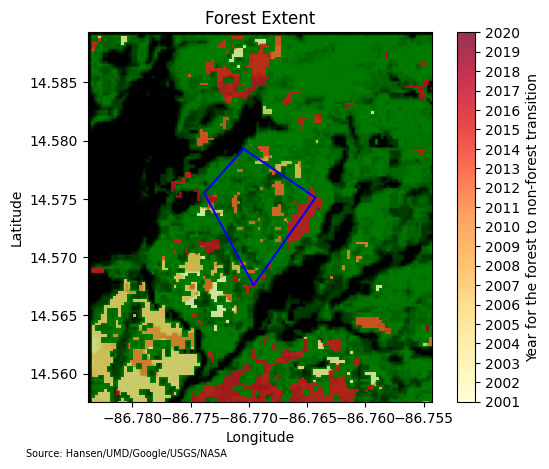

In [6]:
treecover2000 = runs[0].output["merged_raster"][0]
lossyear = runs[1].output["merged_raster"][0]

plot_hansen_map(treecover2000, lossyear, geom, time_range[0].year)

### Plot the proportion of forest/non-forest pixels

In the next cell, the proportion of forest/non-forest pixels is plotted. This is done by analyzing the `lossyear` raster, which represents forest loss over time. The cell calculates the ratio of forest pixels to total pixels within the specified geometry. Then, a pie chart is created using matplotlib to visually compare the proportion of forest and non-forest pixels. Finally, we show the loss table over time in case the user wants to access the values used to plot the graphs.

In [7]:
def read_loss_dict(lossyear: Raster, geom: shpg.Polygon, nodata: int = 255):
    # Read the raster
    loss_image = read_raster(cast(Raster, lossyear), geom, nodata=nodata)[0][0]

    # Count the frequency of each value in the loss_image
    unique, counts = np.unique(loss_image, return_counts=True)

    loss_dict = {uni: count for uni, count in zip(unique, counts)}

    # Delete 255 from the dictionary
    del loss_dict[nodata]

    return loss_dict


def plot_forest_ratio(lossyear: Raster, geom: shpg.Polygon):
    # Read the raster

    loss_dict = read_loss_dict(lossyear, geom)

    # Amount of pixels
    total_pixels = sum(loss_dict.values())

    # Forest Pixels
    forest_pixels = loss_dict[0]
    forest_ratio = forest_pixels / total_pixels

    # Plot a matplotlib pie chart comparing forest and not forest pixels
    labels = "Forest", "Not Forest"

    sizes = [forest_ratio, 1 - forest_ratio]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax1.axis("equal")

    # Title
    plt.title("Forest/Non-Forest pixels proportion")

    plt.show()

### Plot the Forest/Non-Forest pie chart

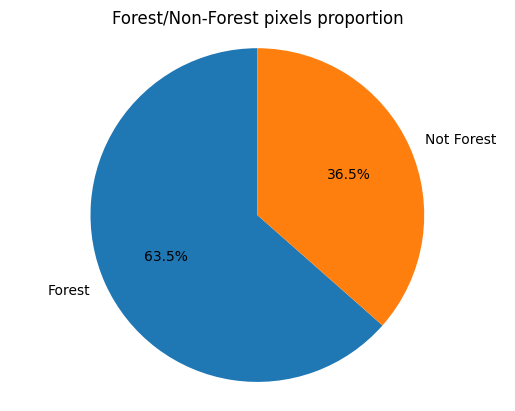

In [8]:
plot_forest_ratio(lossyear, geom)

### Plot the Forest change over time

In the next cell, we create a `plot_forest_loss` function that takes a raster image of forest loss per year and a polygon geometry as inputs. It reads the raster data and calculates the percentage of total forest loss for each year. The function then generates a bar plot with the percentage of forest loss for each year in the dataset.

In [9]:
def plot_forest_loss(lossyear: Raster, geom: shpg.Polygon):
    # Read the raster
    loss_dict = read_loss_dict(lossyear, geom)

    # Amount of pixels
    total_pixels = sum(loss_dict.values())

    # Pixel count
    new_values = {key: 100 * loss_dict[key] / total_pixels for key in loss_dict}

    # Remove the key 0 as it is not a loss. It is the forest
    # pixels that have not been lost.
    new_values.pop(0, None)

    # Create lists of the years and pixel counts
    years = list(new_values.keys())
    years = [year + time_range[0].year for year in years]

    pixel_counts = list(new_values.values())

    # Create a bar plot
    plt.bar(years, pixel_counts)

    # Set the labels for the x and y axes
    plt.xlabel("Year")
    plt.ylabel("Forest Loss (%)")
    plt.title("Forest to Non-Forest affected area (%) over time")

    # Set x-axis to only use integer values
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xticks(range(min(years), max(years) + 1), rotation=90)

    # Show the plot
    plt.show()

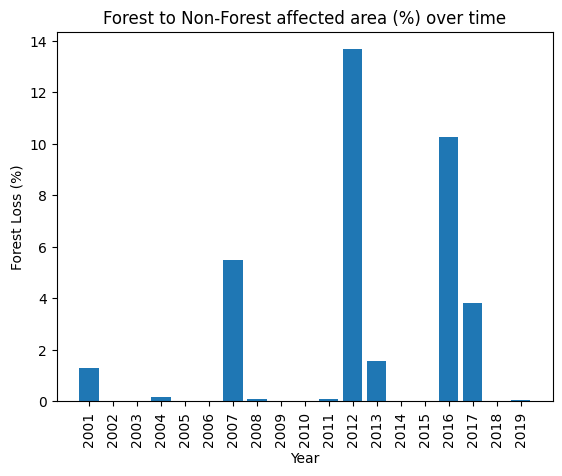

In [10]:
plot_forest_loss(lossyear, geom)

### Displaying the Forest Loss Pixels Over Time

Finally, create a function that reads the forest loss data for each year and plots a table showing the pixel count for each respective year.

In [11]:
def show_loss_table(lossyear: Raster, geom: shpg.Polygon):
    # Read the raster
    loss_dict = read_loss_dict(lossyear, geom)

    # Create a dictionary with the loss_dict values
    data = {
        "Year": [year + time_range[0].year for year in list(loss_dict.keys())[1:]],
        "#Pixels": list(loss_dict.values())[1:],
    }

    # Create a dataframe from the dictionary
    df_loss = pd.DataFrame(data)

    # Sort the dataframe by the 'Year' column
    df_loss = df_loss.sort_values("Year")

    # Reset the index of the dataframe
    df_loss = df_loss.reset_index(drop=True)

    # Amount of pixels
    total_pixels = sum(loss_dict.values())

    return total_pixels, df_loss

In [14]:
total_pixels, df_loss = show_loss_table(lossyear, geom)

print(f"Total pixels: {total_pixels}\n")

# Print the dataframe without the indexes
df_loss

Total pixels: 1786



,Year,#Pixels
0,2001,23
1,2004,3
2,2007,98
3,2008,2
4,2011,2
5,2012,244
6,2013,28
7,2016,183
8,2017,68
9,2019,1
